# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [119]:
import pandas as pd 
data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
#print(data.head(20))

In [120]:
#1.2
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

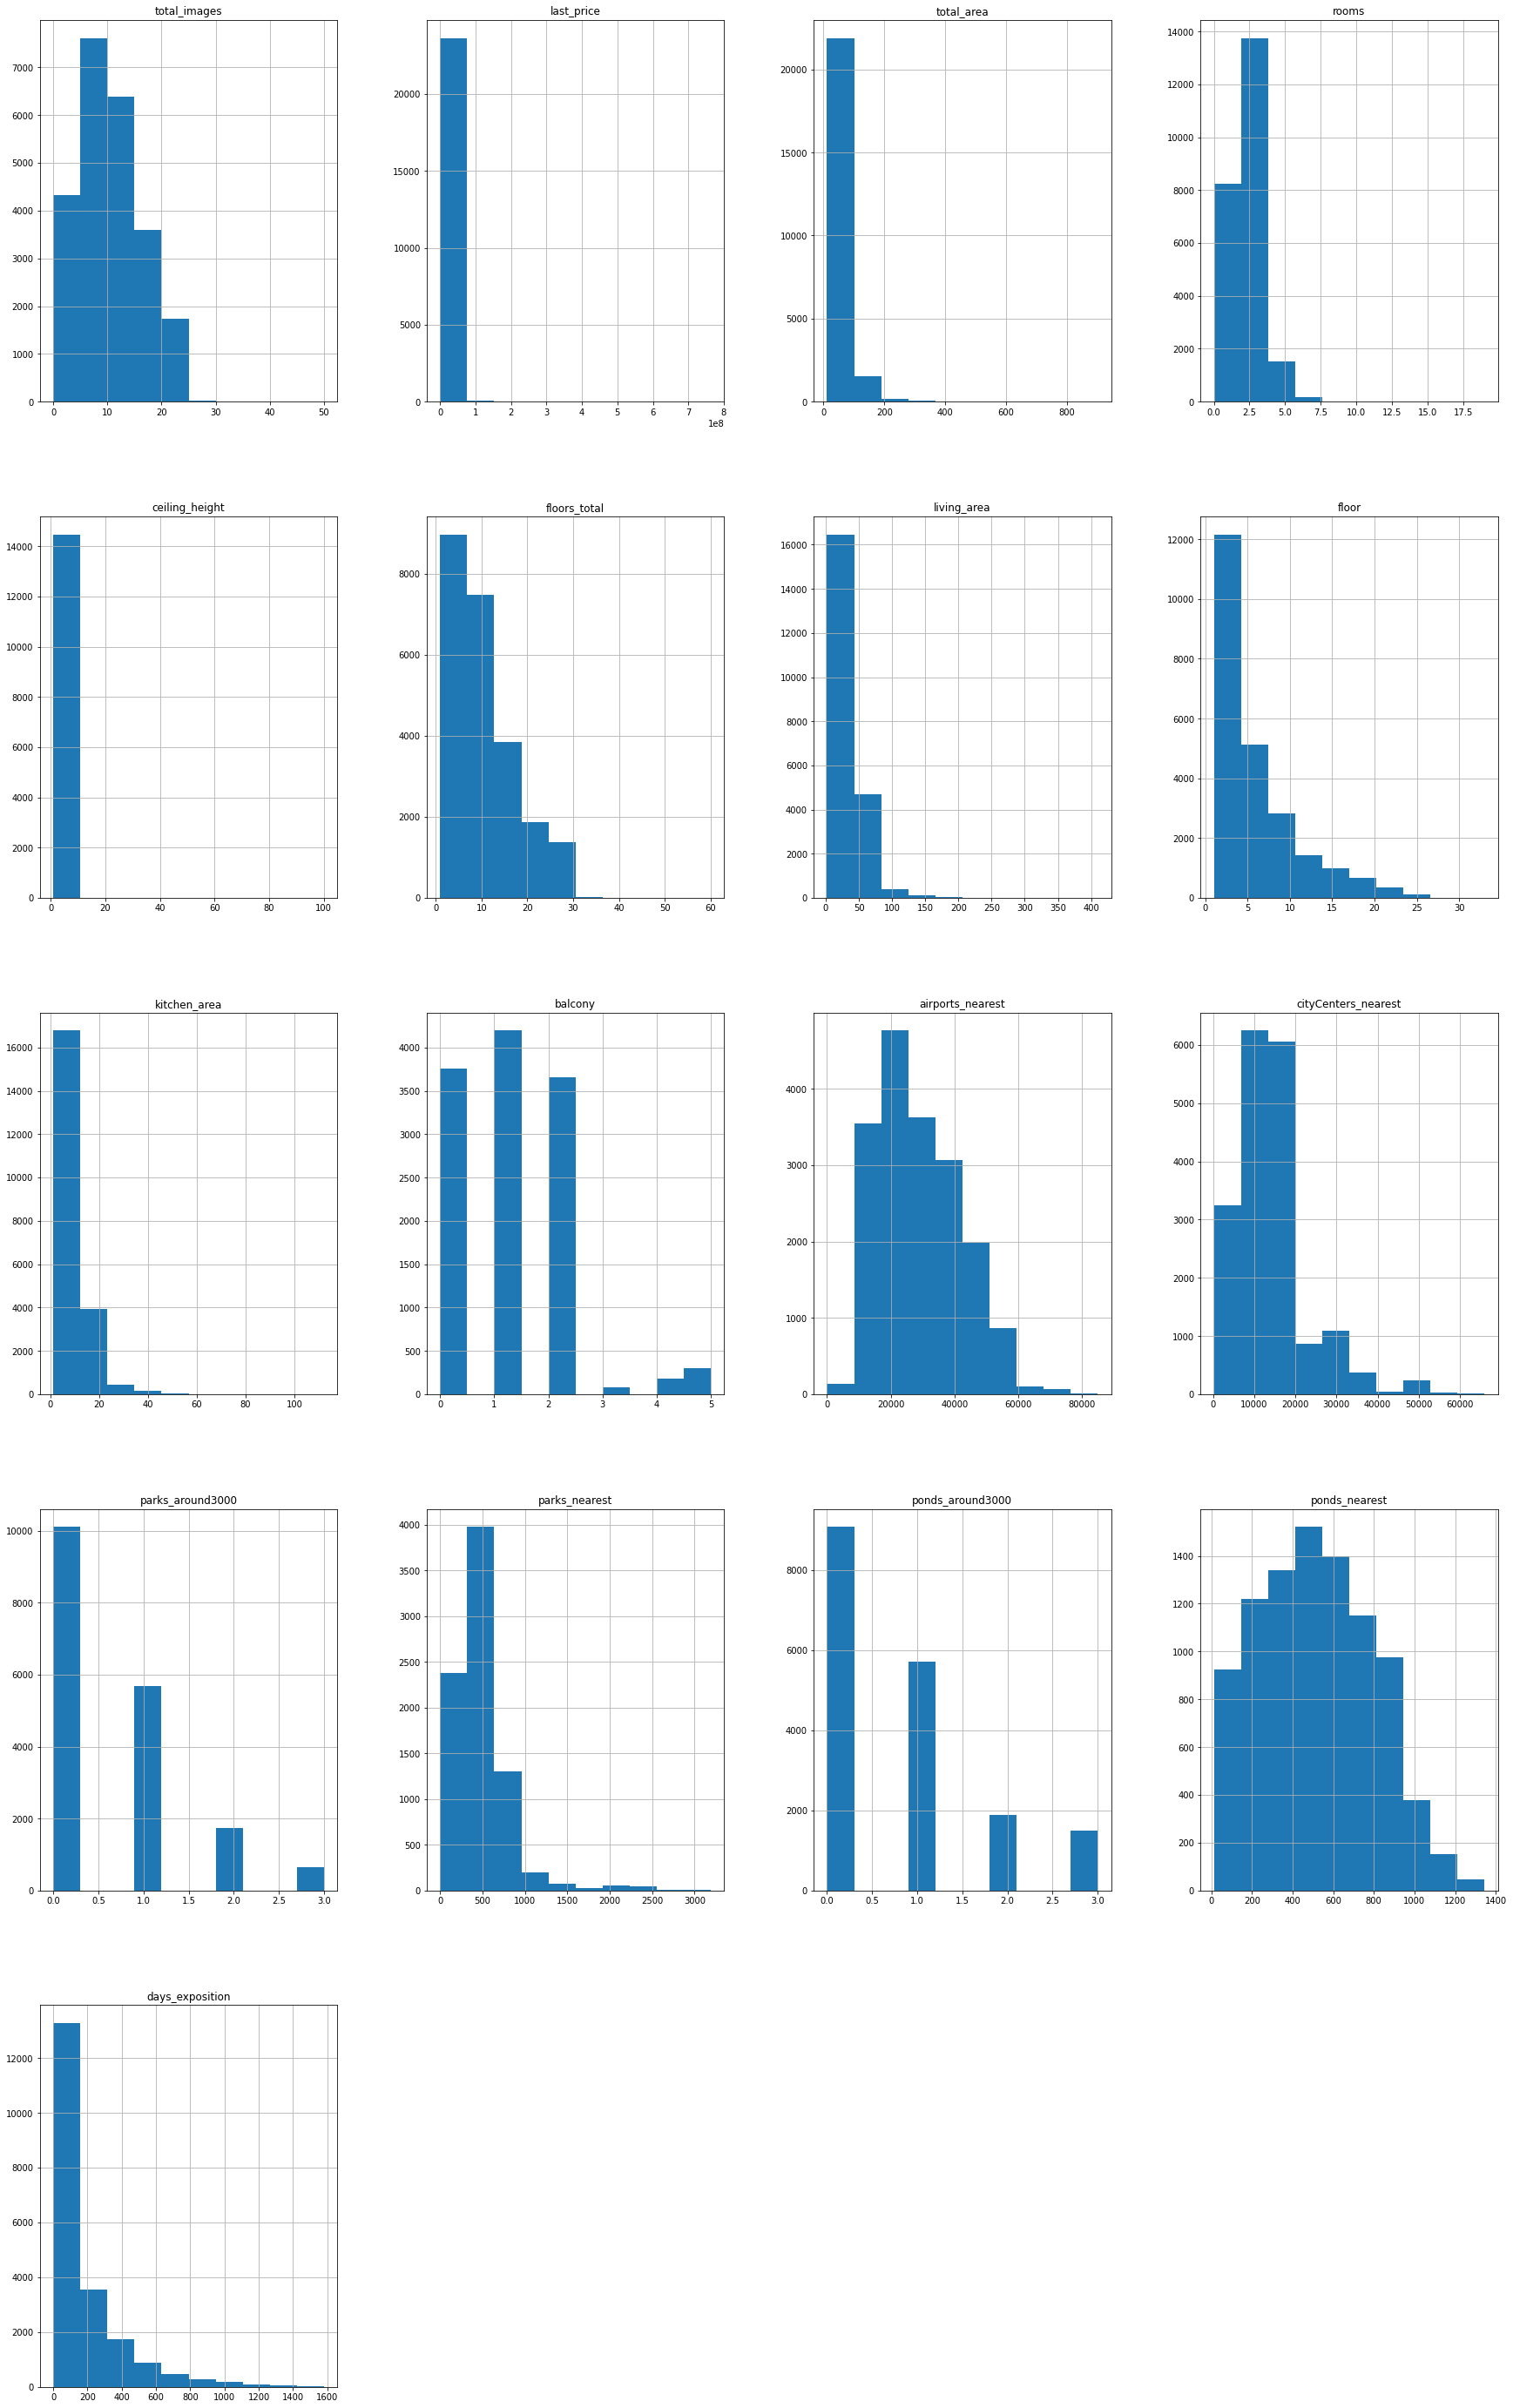

In [121]:
import matplotlib.pyplot as plt

#1.3 гистограммы для всех числовых столбцов таблицы 
data.hist(figsize=(30, 50))

plt.show()

из исходных данных видим что некоторые Колонки имеют пропуски

Значение floors_total, balcony, parks_around3000, ponds_around3000, days_exposition имеет Тип - float64, Хотя Должны быть целочисленные значения

Видим что графики имеют распределение Пуассона.
Имеются нормальные значения и некоторое количество аномальных значений

### Предобработка данных

In [122]:
#2.1 заполняем пропуски в стобце balcony, parks_around3000, ponds_around3000 
#на значение 0 тк вероятно что пропуски потому что нет балконов, парков и прудов в радиусе 3км
data[['balcony', 'parks_around3000', 'ponds_around3000']] = data[['balcony', 'parks_around3000', 'ponds_around3000']].fillna(0)

#проверяем нет ли пропусков 
print(data['balcony'].isna().sum())
print(data['parks_around3000'].isna().sum())
print(data['ponds_around3000'].isna().sum())
#заменить пропуски высоты потолков floors_total на средннее? или медианное? и тогда поменять тип данных

0
0
0


is_apartment булево значение пропуски скорее всего означают то что это квартиры а не апартаменты

данных в колонках airports_nearest cityCenters_nearest parks_nearest ponds_nearest 
пропуски скорее всего потому что нет рядом аэропортов парков итд тк они должны заполняться автоматически

данных в колонке ceiling_height нет изза технической ошибки не выгрузились или их не вбили 

In [123]:
#2.2 меняем значения флот на инт в колонках тк количество целое число и не может быть дробным
data[['balcony', 'parks_around3000', 'ponds_around3000']] = data[['balcony', 'parks_around3000', 'ponds_around3000']].astype('int32')

остальные значения не можем поменять тип данных потому что там есть пропуски

In [124]:
#2.3 Изучите уникальные значения в столбце с названиями и устраните неявные дубликаты

#Заменяем букву 'Ё' на 'Е', заменяем везде где есть 'словосочетание со словом поселок' на 'поселок'

data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['городской поселок', 'поселок при железнодорожной станции', 'поселок городского типа', 'поселок станции', 'поселок имени', 'коттеджный поселок'], 'поселок', regex=True)
    .replace('садоводческое некоммерческое товарищество', 'садовое товарищество', regex=True)
)

# выводим уникальные значения столбца 'locality_name', отсортированые
# print(data['locality_name'].sort_values().unique())
# Считаем количество уникальных значений столбца 'locality_name'
print(data['locality_name'].nunique())



318


In [125]:
# проверяем кол-во явных дубликатов
data.duplicated().sum()

# приводим к нижнему регистра для исключения дубликатов если они имеются
# data['locality_name'] = data['locality_name'].str.lower()

0

вывод по итогу предобработки!
заменили все возможные пропуски:
'balcony', 'parks_around3000', 'ponds_around3000' на 0

is_apartment булево значение пропуски скорее всего означают то что это квартиры а не апартаменты - можно их заменить на значения True?

данных в колонках airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest 
пропуски скорее всего потому что нет рядом аэропортов парков итд тк они должны заполняться автоматически

данных в колонке ceiling_height нет изза технической ошибки - не выгрузились или их не вбили (далее заменяю их на медианное значение)

заменили тип значений:
'balcony', 'parks_around3000', 'ponds_around3000' на int32

заменили неявные дубликаты Содержащие: букву 'ё', словосочетания 'поселок' и 'садовое товарищество'
Проверили наличие явных дубликатов

### Посчитайте и добавьте в таблицу новые столбцы

In [126]:
# цена одного квадратного метра (нужно поделить стоимость объекта 
# на его общую площадь, а затем округлить до двух знаков после запятой);

data['price_m2'] = round(data['last_price']/data['total_area'], 2)

In [127]:
# переводим 'first_day_exposition' в формат datetime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

# добавляем колонку 'weekday_publication' день недели публикации объявления (0 — понедельник, 1 — вторник итд);
data['weekday_publication'] = data['first_day_exposition'].dt.weekday

# добавляем колонку месяц публикации объявления;
data['month_publication'] = data['first_day_exposition'].dt.month

# добавляем колонку год публикации объявления
data['year_publication'] = data['first_day_exposition'].dt.year

In [128]:
# тип этажа квартиры (значения — «первый», «последний», «другой»)

"""
тип этажа квартиры (значения — «первый», «последний», «другой»)
используя правила:
- 'последний' при значении floor = floors_total
- 'первый' при значении floor = 1 
- 'другой' во всех остальных случаях
"""

def floor_type_f(row):

    floors_total = row['floors_total']
    floor = row['floor']

    if floors_total == floor:
        return 'последний'

    if floor == 1:
        return 'первый'

    return 'другой'


In [129]:
data['floor_type'] = data.apply(floor_type_f, axis=1)

In [130]:
#Проверяем количество значений floor_type
data['floor_type'].value_counts()

другой       17446
последний     3361
первый        2892
Name: floor_type, dtype: int64

In [131]:
# расстояние до центра города в километрах (переведите из м в км и округлите до ближайших целых значений).
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest']/1000)

In [132]:
# цена на объект в миллионах
data['price_mln'] = data['last_price']/1000000

### Проведите исследовательский анализ данных

In [133]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'price_m2', 'weekday_publication',
       'month_publication', 'year_publication', 'floor_type',
       'cityCenters_nearest_km', 'price_mln'],
      dtype='object')

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

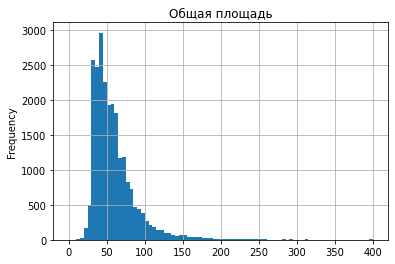

In [134]:
# гистограмма для общей площади
data['total_area'].plot(kind='hist', bins=80, range=(0, 400), title='Общая площадь', grid=True)
data['total_area'].describe()

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

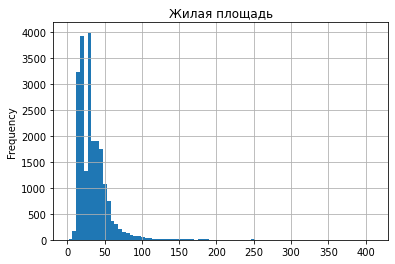

In [135]:
# гистограмма для жилой площади
data['living_area'].plot(kind='hist', bins=80, title='Жилая площадь', grid=True)
data['living_area'].describe()

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

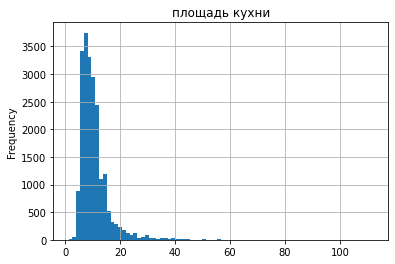

In [136]:
# гистограмма для площади кухни
data['kitchen_area'].plot(kind='hist', bins=80, title='площадь кухни', grid=True)
data['kitchen_area'].describe()

count    2.369900e+04
mean     9.942166e+04
std      5.030680e+04
min      1.118300e+02
25%      7.658547e+04
50%      9.500000e+04
75%      1.142563e+05
max      1.907500e+06
Name: price_m2, dtype: float64

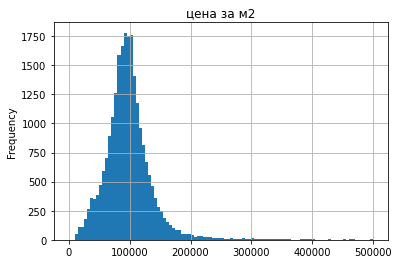

In [137]:
# гистограмма для цены за метр2
data['price_m2'].plot(kind='hist', bins=100, title='цена за м2', grid=True, range=(0, 500000))
data['price_m2'].describe()
#data[data['price_m2'] > 500000]

имеются очень дорогие объекты которые могут влиять на среднее > 500000, но их мало! 
поэтому ограничили гистограмму до 500000

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

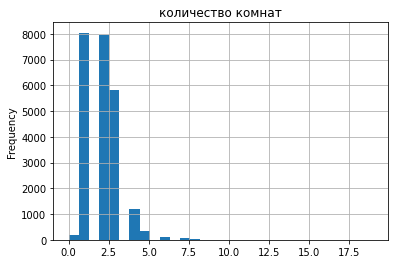

In [138]:
# гистограмма для количества комнат
data['rooms'].plot(kind='hist', bins=30, title='количество комнат', grid=True)
data['rooms'].describe()

есть квартиры с количеством комнат 0!!! 
у квартиры не модет быть 0 комнат вероятно это непрвильно заполнено

заменяем объекты с 0 комнатами и меньше 45 м2 на 1-комнатные 

In [139]:
data.loc[(data['total_area'] <= 45) & (data['rooms'] == 0), 'rooms'] = 1

остается 5 объектов с количеством комнат = 0, вероятно с неуказанными количеством комнат!!!  удалим их  

In [140]:
data = data[data['rooms'] != 0]


#data.plot(x='price_m2', y='total_area', style='o', xlim=(0, 400000), ylim=(0, 300), grid=True, figsize=(15, 10))

In [141]:
#проверяем остались ли 0
data.query('rooms == 0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_m2,weekday_publication,month_publication,year_publication,floor_type,cityCenters_nearest_km,price_mln


count    14500.000000
mean         2.771176
std          1.260951
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

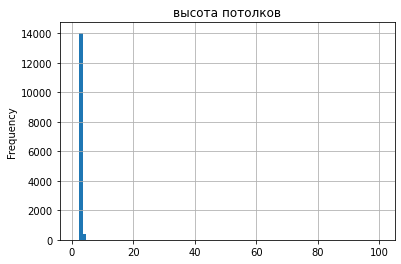

In [142]:
# гистограмма для высоты потолков 
data['ceiling_height'].plot(kind='hist', bins=80, title='высота потолков', grid=True)
data['ceiling_height'].describe()

In [143]:
# выводим уникальные значения высоты потолков 
print(data['ceiling_height'].sort_values().unique())

# делим значения ceiling_height которые >=19 на 10, тк вероятно их записали непрвыильно
# 25 м и 32 м. Логично предположить, что на самом деле это вещественные значения: 2.5 м и 3.2 м.

data.loc[(data['ceiling_height'] >=19), 'ceiling_height'] = data[data['ceiling_height'] >=19]['ceiling_height'] / 10

[  1.     1.2    1.75   2.     2.2    2.25   2.3    2.34   2.4    2.45
   2.46   2.47   2.48   2.49   2.5    2.51   2.52   2.53   2.54   2.55
   2.56   2.57   2.58   2.59   2.6    2.61   2.62   2.63   2.64   2.65
   2.66   2.67   2.68   2.69   2.7    2.71   2.72   2.73   2.74   2.75
   2.76   2.77   2.78   2.79   2.8    2.81   2.82   2.83   2.84   2.85
   2.86   2.87   2.88   2.89   2.9    2.91   2.92   2.93   2.94   2.95
   2.96   2.97   2.98   2.99   3.     3.01   3.02   3.03   3.04   3.05
   3.06   3.07   3.08   3.09   3.1    3.11   3.12   3.13   3.14   3.15
   3.16   3.17   3.18   3.2    3.21   3.22   3.23   3.24   3.25   3.26
   3.27   3.28   3.29   3.3    3.31   3.32   3.33   3.34   3.35   3.36
   3.37   3.38   3.39   3.4    3.42   3.43   3.44   3.45   3.46   3.47
   3.48   3.49   3.5    3.51   3.52   3.53   3.54   3.55   3.56   3.57
   3.58   3.59   3.6    3.62   3.63   3.65   3.66   3.67   3.68   3.69
   3.7    3.75   3.76   3.78   3.8    3.82   3.83   3.84   3.85   3.86
   3.8

делим значения ceiling_height которые >=19 на 10, тк вероятно их записали непрвыильно
25 м и 32 м. 
Логично предположить, что на самом деле это вещественные значения: 2.5 м и 3.2 м.


In [144]:
print(data['ceiling_height'].sort_values().unique())

[ 1.    1.2   1.75  2.    2.2   2.25  2.26  2.3   2.34  2.4   2.45  2.46
  2.47  2.48  2.49  2.5   2.51  2.52  2.53  2.54  2.55  2.56  2.57  2.58
  2.59  2.6   2.61  2.62  2.63  2.64  2.65  2.66  2.67  2.68  2.69  2.7
  2.71  2.72  2.73  2.74  2.75  2.76  2.77  2.78  2.79  2.8   2.81  2.82
  2.83  2.84  2.85  2.86  2.87  2.88  2.89  2.9   2.91  2.92  2.93  2.94
  2.95  2.96  2.97  2.98  2.99  3.    3.01  3.02  3.03  3.04  3.05  3.06
  3.07  3.08  3.09  3.1   3.11  3.12  3.13  3.14  3.15  3.16  3.17  3.18
  3.2   3.21  3.22  3.23  3.24  3.25  3.26  3.27  3.28  3.29  3.3   3.31
  3.32  3.33  3.34  3.35  3.36  3.37  3.38  3.39  3.4   3.42  3.43  3.44
  3.45  3.46  3.47  3.48  3.49  3.5   3.51  3.52  3.53  3.54  3.55  3.56
  3.57  3.58  3.59  3.6   3.62  3.63  3.65  3.66  3.67  3.68  3.69  3.7
  3.75  3.76  3.78  3.8   3.82  3.83  3.84  3.85  3.86  3.87  3.88  3.9
  3.93  3.95  3.98  4.    4.06  4.1   4.14  4.15  4.19  4.2   4.25  4.3
  4.37  4.4   4.45  4.5   4.65  4.7   4.8   4.9   5.   

In [145]:
# считаем количество объектов у которых аномально высокие потолки больше 6м
data.query('ceiling_height >= 6')['ceiling_height'].value_counts()

8.0     3
14.0    1
10.0    1
10.3    1
8.3     1
6.0     1
Name: ceiling_height, dtype: int64

In [146]:
# считаем количество объектов у которых потолки < 1.9м
data.query('ceiling_height <= 1.9')['ceiling_height'].value_counts()

1.00    1
1.75    1
1.20    1
Name: ceiling_height, dtype: int64

In [147]:
# считаем медиану высоты потолков которые больше 1,9 м
data.query('ceiling_height >= 1.9')['ceiling_height'].median()

2.65

In [148]:
# заменяем высоту потолков которые ниже 1,9м на медианное значение 
data.loc[(data['ceiling_height'] <= 1.9), 'ceiling_height'] = data.query('ceiling_height >= 1.9')['ceiling_height'].median()

In [149]:
# заменяем Значения ceiling_height С пропусками на медианное значение
data.loc[(data['ceiling_height'].isna()), 'ceiling_height'] = data.query('ceiling_height >= 1.9')['ceiling_height'].median()
# проверяем пропуски
print(data['ceiling_height'].isna().sum())

0


In [150]:
data['floor_type'].value_counts()
#data.info()

другой       17443
последний     3360
первый        2891
Name: floor_type, dtype: int64

count    23608.000000
mean        10.674941
std          6.597389
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

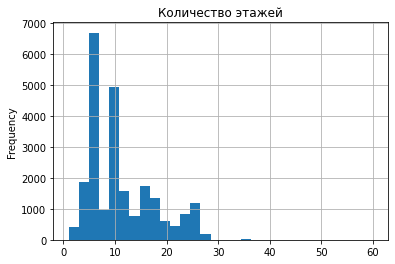

In [151]:
# гистограмма Количества этажей в доме
data['floors_total'].plot(kind='hist', bins=30, title='Количество этажей', grid=True)
data['floors_total'].describe()

In [152]:
#data['floors_total'].value_counts()

аномально высоких домов нет, все в пределах нормы

In [153]:
#data.query('rooms == 0').describe()
#stat = data.pivot_table(index='rooms', values='last_price')

count    18175.000000
mean     14193.668116
std       8608.278994
min        181.000000
25%       9238.000000
50%      13101.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

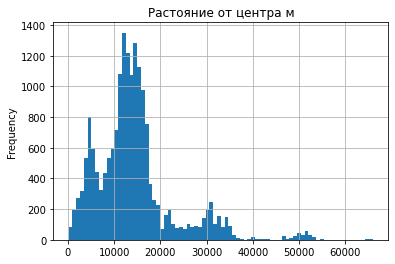

In [154]:
# гистограмма Растояния от центра города в метрах
data['cityCenters_nearest'].plot(kind='hist', bins=80, title='Растояние от центра м', grid=True)
data['cityCenters_nearest'].describe()

Расстояние от центра города в среднем от 0 до 60 км

count    8077.000000
mean      490.795345
std       342.340243
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

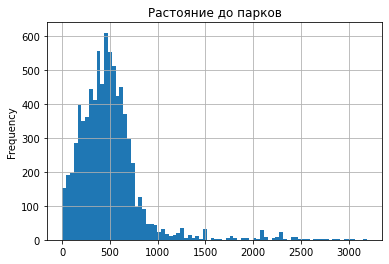

In [155]:
# гистограмма Растояния до парков в метрах 
data['parks_nearest'].plot(kind='hist', bins=80, title='Растояние до парков', grid=True)
data['parks_nearest'].describe()

в основном указывают растояние до парка если он близко до 3000 м,  в остальных случаях не указывают !!!

count    20514.000000
mean       180.888954
std        219.730280
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

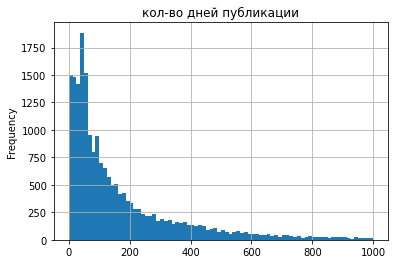

In [156]:
# гистограмма кол-во дней публикации
data['days_exposition'].plot(kind='hist', bins=80, range=(0,1000), title='кол-во дней публикации', grid=True)
data['days_exposition'].describe()

- min -  1 день возможно это пробные объявления Или заблокированые итд , а возможно быстро продали 

- max - самое долгое 1580 дней 
- среднее кол-во дней продажи 180
- медеанное кол-во дней продажи 95

- больше 600 дней считается необычно долгими
- до 45 дней можно считать быстрыми

45.0    880
60.0    537
7.0     234
30.0    207
90.0    203
4.0     176
3.0     158
5.0     152
14.0    148
9.0     143
Name: days_exposition, dtype: int64

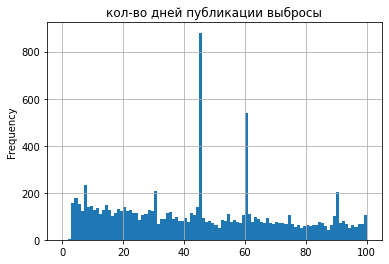

In [157]:
# гистограмма кол-во дней публикации возможные выбросы!
data['days_exposition'].plot(kind='hist', bins=100, range=(0,100), title='кол-во дней публикации выбросы', grid=True)
# выводим 10 дней когда чаще всего снимают обьекты с продажи
data['days_exposition'].value_counts().head(10)


выбросы 45 и 60 дней 

In [158]:
# округляем значение в колонке days_exposition целых
data['days_exposition'] = round(data['days_exposition'], 0)
data.loc[23695, 'days_exposition']

45.0

округли значения в колонке days_exposition до целых чтобы можно было проверить и посчитать в каких городах выбросы 45 и 60 дней

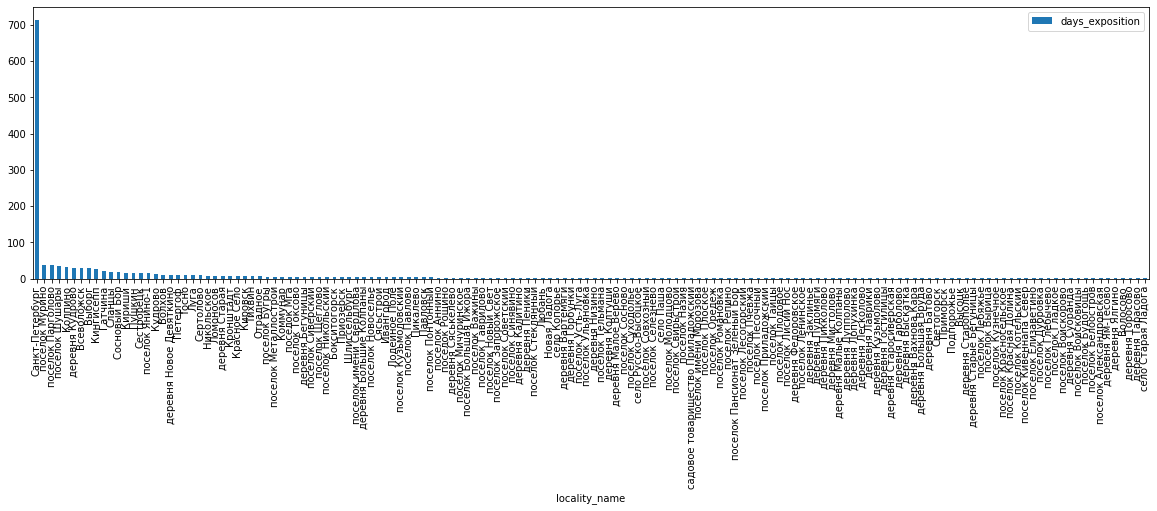

In [159]:
#проверим и посчитаем в каких городах данные выбросы 45 и 60 дней
(
data
.query('days_exposition == 45 or days_exposition == 60')
.pivot_table(index='locality_name', values='days_exposition', aggfunc='count')
.sort_values(by='days_exposition', ascending=False)
.plot(kind='bar', figsize=(20, 5))
)
plt.show()

видим что в основном это в Спб - большой город

выбросы 45 и 60 дней 

гипотезы: 
- бесплатный период пользователи должны оплатить чтобы объявление висело дальше (какие то платные услуги) пользователи не оплачивают и объявление снимается 
- просто подтвердить актуальность объявления (но не все это делают)
- пользователи проплатили размещения объявления на определенный срок
- в большом городе таком как СПБ размещение объявлений платное а в маленьких - бесплатное
- в большом городе объекты продаются быстрее

0.6530147932890691


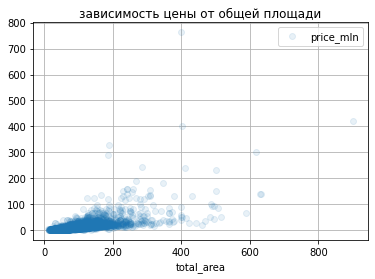

In [160]:
# смотрим зависимость на графике цены от общей площади
data.plot(x='total_area', y='price_mln', style='o', grid=True, figsize=(6, 4), alpha=0.1, title='зависимость цены от общей площади')
# считаем коэф корреляции
print(data['price_mln'].corr(data['total_area']))

видим линейную зависимость цены от общей площади

0.5664955457898883


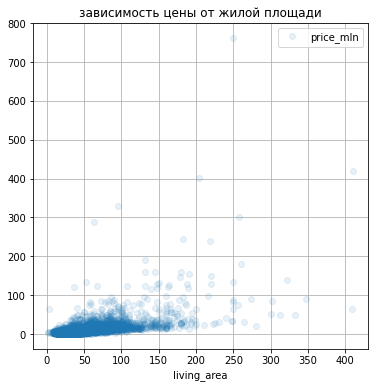

In [161]:
# смотрим зависимость на графике цены от жилой площади
data.plot(x='living_area', y='price_mln', style='o', grid=True, figsize=(6, 6), alpha=0.1, title='зависимость цены от жилой площади')
# считаем коэф корреляции
print(data['price_mln'].corr(data['living_area']))

тоже самое! Видим зависимость цены от жилой площади

0.5198690130216389


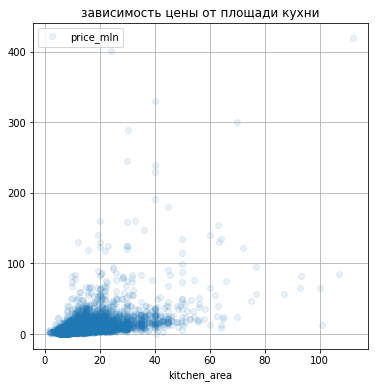

In [162]:
# смотрим зависимость на графике цены от площади кухни
data.plot(x='kitchen_area', y='price_mln', style='o', grid=True, figsize=(6, 6), alpha=0.1, title='зависимость цены от площади кухни')
# считаем коэф корреляции
print(data['price_mln'].corr(data['kitchen_area']))

Видим зависимость цены от площади кухни

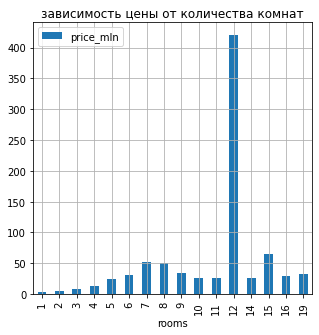

In [163]:
#data.plot(x='rooms', y='price_mln', xlim=(0, 15), style='o', grid=True, figsize=(6, 6), alpha=0.3)


# смотрим зависимость на графике цены от количества комнат
(
data
.pivot_table(index='rooms', values='price_mln', aggfunc='mean')
.plot(kind='bar', grid=True, figsize=(5, 5), title='зависимость цены от количества комнат')
)
plt.show()

In [164]:
data['rooms'].value_counts()

1     8239
2     7940
3     5814
4     1180
5      326
6      105
7       59
8       12
9        8
10       3
11       2
14       2
16       1
19       1
12       1
15       1
Name: rooms, dtype: int64

- Видим что квартиры Увеличиваются в цене от количество комнат, 
от 1 комнатных до 6 комнатных
- Далее где кол-во комнат 7 и выше - график не репрезентативен так как мало данных

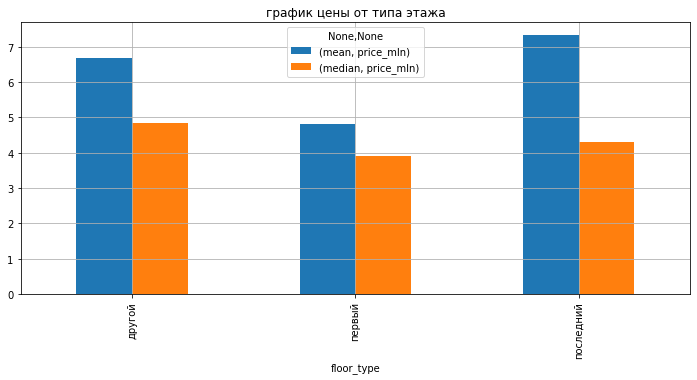

In [165]:
# строим график средний и медианы цены от типа этажа
price_floor = (data
                    .pivot_table(index='floor_type', values='price_mln', aggfunc=['mean', 'median'])
                    .plot(kind='bar', grid=True, figsize=(12, 5), title='график цены от типа этажа')
              )
# price_floor.columns = ['mean', 'median']   
#round(price_floor, 2)

квартира на первом этаже Стоят дешевле остальных

,price_mln
year_publication,
2014,7.70
2015,5.35
2016,4.55
2017,4.50
2018,4.55
2019,5.05


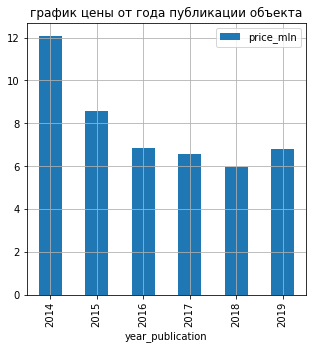

In [166]:
# смотрим зависимость на графике цены от года публикации объекта
(
data
.pivot_table(index='year_publication', values='price_mln', aggfunc='mean')
.plot(kind='bar', grid=True, figsize=(5, 5), title='график цены от года публикации объекта')
)

data.pivot_table(index='year_publication', values='price_mln', aggfunc='median')

In [167]:
# кол-во объектов выставенных на продажу по годам
data['year_publication'].value_counts()

2018    8518
2017    8187
2019    2878
2016    2783
2015    1191
2014     137
Name: year_publication, dtype: int64

In [168]:
# кол-во объектов выставенных на продажу по годам и кол-ву комнат
data.pivot_table(index='year_publication', columns='rooms', values='price_mln', aggfunc='count')

rooms,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,19
year_publication,,,,,,,,,,,,,,,,
2014,28.0,38.0,46.0,19.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,309.0,380.0,351.0,97.0,42.0,7.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2016,926.0,903.0,701.0,188.0,48.0,8.0,3.0,2.0,1.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN
2017,2891.0,2748.0,1983.0,381.0,107.0,34.0,33.0,4.0,3.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN
2018,3134.0,2867.0,1994.0,374.0,91.0,40.0,11.0,3.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0
2019,951.0,1004.0,739.0,121.0,33.0,15.0,11.0,NaN,3.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN


- в 2014 году было выставлено всего 137 объектов - поэтому выборка за этот год нерепрезентативана
- в 2015-2018 годах видим тенденцию снижения цены
- в 2019 году цена снова возврасла относительно 2018 года 

In [169]:
# средняя и медианная цена выставенных на продажу объектов по месяцам
round(data.pivot_table(index='month_publication', values='price_mln', aggfunc=['median', 'mean']), 2) 

,median,mean
,price_mln,price_mln
month_publication,,
1,4.60,6.67
2,4.65,6.47
3,4.65,6.36
4,4.80,6.74
5,4.50,6.60
6,4.40,6.31
7,4.65,6.61
8,4.57,6.35


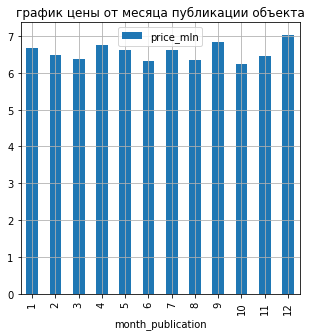

In [170]:
# смотрим зависимость на графике цены от месяца публикации объекта
(
data
.pivot_table(index='month_publication', values='price_mln', aggfunc='mean')
.plot(kind='bar', grid=True, figsize=(5, 5), title='график цены от месяца публикации объекта')
)
plt.show()

не наблюдается зависимость Цены от месяца

                       median      mean
                    price_mln price_mln
weekday_publication                    
0                       4.650  6.511613
1                       4.730  6.394233
2                       4.700  6.625536
3                       4.650  6.693526
4                       4.580  6.371241
5                       4.555  6.976804
6                       4.550  6.246180


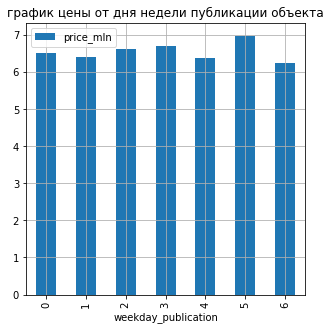

In [171]:
# смотрим зависимость на графике цены от дня недели публикации объекта
print(data.pivot_table(index='weekday_publication', values='price_mln', aggfunc=['median', 'mean']))
(
data
.pivot_table(index='weekday_publication', values='price_mln', aggfunc='mean')
.plot(kind='bar', grid=True, figsize=(5, 5), title='график цены от дня недели публикации объекта')
)
plt.show()

не наблюдается зависимость цены от дня недели публикации объекта

Исходя из графиков видим что:
- цена зависит от общей площади, жилой площади, площади кухни: больше площадь - выше цена
- от кол-ва комнат: больше комнат - выше цена
- типа этажа: на первом этаже - дешевле 
- года публикации: 2015-2018 годах цены снижались, 
в 2019 году цена возврасла относительно 2018 года
- от месяца и дня публикации цена не зависит

In [172]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'price_m2', 'weekday_publication',
       'month_publication', 'year_publication', 'floor_type',
       'cityCenters_nearest_km', 'price_mln'],
      dtype='object')

In [173]:
#4.4 10 населённых пунктов с наибольшим числом объявлений
price_10 = data['locality_name'].value_counts()
price_10.head(10).index

Index(['Санкт-Петербург', 'поселок Мурино', 'поселок Шушары', 'Всеволожск',
       'Пушкин', 'Колпино', 'поселок Парголово', 'Гатчина', 'деревня Кудрово',
       'Выборг'],
      dtype='object')

In [174]:
# строим сводную таблицу с количеством объявлений и средней ценой квадратного метра для 
# 10 населённых пунктов с наибольшим числом объявлений.
# + сбрасываем индексы
df =(
    data.query('locality_name in @price_10.head(10).index')
    .pivot_table(index='locality_name', values='price_m2', aggfunc=['mean', 'count'])
).reset_index()

# преименовываем столбцы
df.columns = ['locality_name', 'mean_price_m2', 'count_price_m2' ]
# сортируем по столбцу средней цены по Убыванию 
df = round(df.sort_values(by='mean_price_m2', ascending=False))
print(df)

       locality_name  mean_price_m2  count_price_m2
5    Санкт-Петербург       114840.0           15716
4             Пушкин       103126.0             369
6    деревня Кудрово        92474.0             299
8  поселок Парголово        90176.0             327
7     поселок Мурино        85682.0             556
9     поселок Шушары        78677.0             440
3            Колпино        75425.0             338
2            Гатчина        68746.0             307
0         Всеволожск        68654.0             398
1             Выборг        58142.0             237


In [175]:
# выводим первую(max) и последнию(min) строки
print('cамая высокая цена за м2', df.iloc[0,:])
print()
print('cамая низкая цена за м2' , df.iloc[-1,:])

cамая высокая цена за м2 locality_name     Санкт-Петербург
mean_price_m2            114840.0
count_price_m2              15716
Name: 5, dtype: object

cамая низкая цена за м2 locality_name      Выборг
mean_price_m2     58142.0
count_price_m2        237
Name: 1, dtype: object


- в Выборге самая дешевая средняя цена за м2 = 58142
- в Санкт-Петербург самая дорогая средняя цена за м2 = 114840

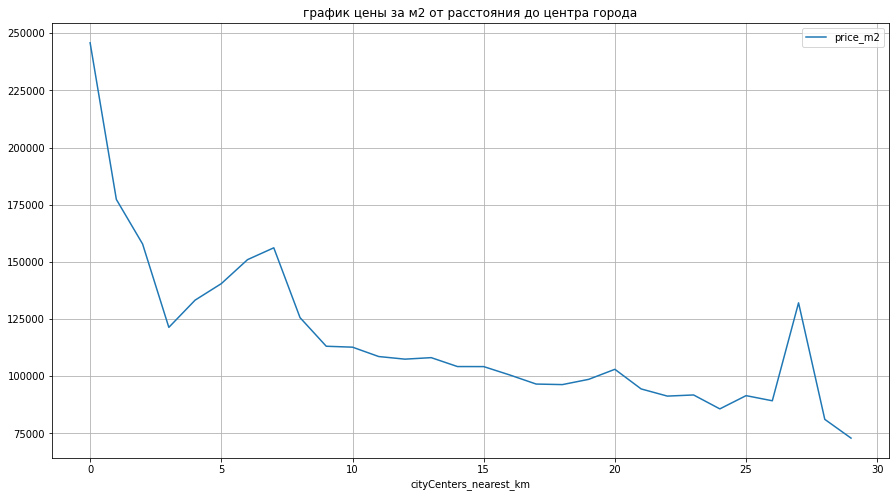

In [176]:
#4.5 делаем срез по столбцу 'locality_name' где значения только 'Санкт-Петербург'
# делаем сводную таблицу, группируем по расстоянию в километрах, считаем среднюю цену за м2
# строим график цены от расстояния
spb_km_price_m2 = ( data
                    .query('locality_name == "Санкт-Петербург"')
                    .pivot_table(index='cityCenters_nearest_km', values='price_m2', aggfunc='mean')
                    .plot(y='price_m2', grid=True, figsize=(15, 8), title='график цены за м2 от расстояния до центра города')
                )
spb_km_price_m2
plt.show()

- чем ближе к центру тем дороже средняя цена за м2
- дороже всего средняя цена за м2 Объектов Которые находятся на расстоянии до 3 км от центра

Зона центра города заканчивается на 8-10 км. После пика цены за квадратный метр на 6 км.

### Общий вывод

Проанализировав рынок недвижимости 
- Видим закономерность, что на цену влияет Общая площадь объекта, жилая площадь объекта и площадь кухни - Чем выше площадь тем выше цена
- количество комнат - больше комнат выше цена 

Квартиры на первом этаже стоит дешевле остальных

Проанализировали как быстро Продаются объекты:
- min -  1 день возможно это пробные объявления Или заблокированые итд , а возможно быстро продали 
- max - самое долгое 1580 дней 
- среднее кол-во дней продажи 180
- медеанное кол-во дней продажи 95
- больше 600 дней считается необычно долгими
- до 40 дней можно считать быстрыми

Проанализировали цену объектов в зависимости от года публикации:
- в 2014 году было выставлено всего 137 объектов - поэтому выборка за этот год нерепрезентативана
- в 2015-2018 годах видим тенденцию снижения цены
- в 2019 году цена возврасла относительно 2018 года 

- Выявили зависимость цены объекта от Удалённости от центра - чем ближе к центру тем дороже
- дороже всего средняя цена за м2 Объектов Которые находятся на расстоянии до 3 км от центра
Зона центра города заканчивается на 8-10 км.

Определили Самую высокую и самую низкую цену за 1 м² в самых распростаненых городах где продают объекты:
- в Выборге самая дешевая средняя цена за м2 = 58141.91
- в Санкт-Петербург самая дорогая средняя цена за м2 = 114840.26

обратить внимание на: 
параметры: 
- общая площадь, жилая площадь, площадь кухни, количество комнат, этаж, удаленность от центра, наличие и удаленость парков и прудов 
разбить объекты по группам с этими параметрами
- посмотреть средние цены на объекты в каждой группе с определеными параметрами и на аномальные цены для объектов в этих группах 

если цена сильно расходится то возможно это мошенники


**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [ ]  определены пропущенные значения
- [ ]  заполнены пропущенные значения там, где это возможно
- [ ]  есть пояснение, какие пропущенные значения обнаружены
- [ ]  изменены типы данных
- [ ]  есть пояснение, в каких столбцах изменены типы и почему
- [ ]  устранены неявные дубликаты в названиях населённых пунктов
- [ ]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [ ]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [ ]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [ ]  посчитано и добавлено в таблицу: месяц публикации объявления
- [ ]  посчитано и добавлено в таблицу: год публикации объявления
- [ ]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [ ]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [ ]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [ ]  построены гистограммы для каждого параметра
- [ ]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [ ]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [ ]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [ ]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [ ]  в каждом этапе есть промежуточные выводы
- [ ]  есть общий вывод